# An introduction to data generator with Keras

Keras is an API that allows to easly manage deep learning algorithms. However, when we want to train a FCNN for segmentation we need to properly upload the training data. We cannot use the standard module ImageDataGenerator and we need to write a specific generator.

A data generator is an iterator that allows us to choose the couple of input data image and label. We need to define a new generator since you may have to handle very big dataset and hence it could not be possible to load the entire dataset at once. This introduction is made to let you understand how to build a real-time generator for CNN.

Let's import the packages we need:

In [1]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

A DataGenerator is a class defined through the class Sequence. We first need to initialize the function.
This code contains comments that are useful to understand each single part of the DataGenerator. There are also few questions that needs to be answered in the comments that are resumed below the definition.

In [2]:
class DataGenerator(Sequence):

    ''' Datagenerator for U_Net:
    Parameters---------------------
    path : path to input images
    list_X : list, indexes to call training data
    batch_size : integer, number of images per batch
    dim : tuple, integer, size of input images
    shuffle: boolean, shuffle=True means data are shuffled during calling.'''

    def __init__(self, path, list_X, batch_size=1, dim=(128,128), shuffle=True):
        'Initialization'
        self.dim=dim
        self.batch_size = batch_size
        self.list_X = list_X
        self.path = path
        self.shuffle = shuffle
        self.on_epoch_end()
        
    ''' We define here the methods/attributes we need. The first one is len: 
    we use it to return the batch index that the CNN is using at one moment during training.
    It is equal to the ratio of the number of samples over the batch size. If we have 120 
    samples and batch size equal to 4, the len is 30.'''

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_X) / self.batch_size))

    '''Now, when the batch corresponding to a given index is called, the generator executes 
    the __getitem__ method to generate it.'''
    
    def __getitem__(self, index):
        'Generate one batch of data: When are the image indices reshuffled?'
        # Generate indexes of a single batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_X_temp = [self.list_X[k] for k in indexes]

        # Generate data using the method __data_generation that we
        # will define later.
        X, y = self.__data_generation(list_X_temp, self.path)

        return X, y

    def on_epoch_end(self):
        ''' This method is used to update indices after each epoch. This is very VERY important, why?
        (because CNN are prone to learn the data order.)'''
        self.indexes = np.arange(len(self.list_X))
        if self.shuffle == True:
            'where do we set shuffle=True?'
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_X_temp, path):  
        '''This method is the core of a data generator. We first initialize the
        array containing the input data and the labels.'''
        # Initialization: we define empty arrays with batch size as (batch) sample dimension.
        # Then we put the image size (where is the image size defined?) and the number of channel.
        # Grayscale images have 1 channel.
        
        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size, *self.dim, 1))

        # Generate data
        for i, j in enumerate(list_X_temp): # what is the dimension of list_X_temp?
            # We read the pre-processed data.
            arr=np.load(os.path.join(path, str(j)))
            
           # img = np.zeros((arr.shape[0], arr.shape[1]))
           # seg = np.zeros((arr.shape[0], arr.shape[1]))
            
           # img[:,:]=arr[:,:,0]
           # seg[:,:]=arr[:,:,1]

            X[i] = np.expand_dims(arr[:,:,0], axis=-1)
            y[i] = np.expand_dims(arr[:,:,1], axis=-1)

        return X, y

**QUESTIONS:**
1) When are the image indices reshuffled?
2) Why indices reshuffling is so important?
3) Where do we set suffhle=True?
4) What is the dimension of list_X_temp?

We could perform also data augmentation with the above generator. Where should it be performed? What happens if we implement data augmentation in the generator?

## Download the data

execute the ```get_data.sh``` script:

In [3]:
dim = 128  # Available dimensions: 128, 256, 512

# Allow for overriding in tests
dim = os.environ.get("UNET_SHEZEN_DIM", dim)

data_url = {128: '0e1e5d/dl/Shezen_128128.zip', 256: '3a4a44/dl/Shezen_256256.zip', 512: '80a4eb/dl/Shezen_512512.zip'}

if not os.path.exists(f"../Shezen_{dim:d}{dim:d}"):
    ! wget https://pandora.infn.it/public/{data_url[dim]} -qO tmp.zip
    ! unzip -q tmp.zip 
    ! rm -rf tmp.zip
    ! mv ./Shezen_{dim}{dim} ../Shezen_{dim}{dim}

path='../Shezen_{:d}{:d}/'.format(dim,dim) # input images path
data_path= path + '*'

data already downloaded
/jupyter-workspace/private/Shezen_128128


We wrote the datagenerator! We are going to test if it works properly. Let's test the data generator!

In [4]:
data_path = os.path.join(path,'*') # list of images name
data_list = [os.path.basename(f) for f in glob(data_path)] 

''' we select only ten patients for the test'''

data_list = data_list[0:10]

print(data_list)

['CHNCXR_0317_0_mask.npy', 'CHNCXR_0267_0_mask.npy', 'CHNCXR_0527_1_mask.npy', 'CHNCXR_0404_1_mask.npy', 'CHNCXR_0626_1_mask.npy', 'CHNCXR_0093_0_mask.npy', 'CHNCXR_0077_0_mask.npy', 'CHNCXR_0016_0_mask.npy', 'MCUCXR_0094_0.npy', 'MCUCXR_0038_0.npy']


In [5]:
dg_test = DataGenerator(path, list_X=data_list, batch_size = 1) # we call the data generator

We plot the images with the labes of the selected cases.

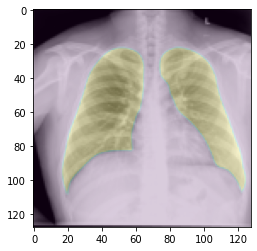

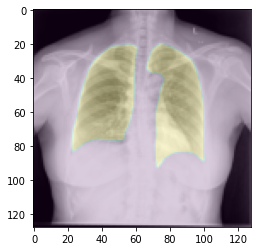

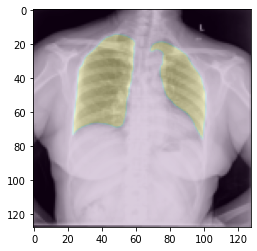

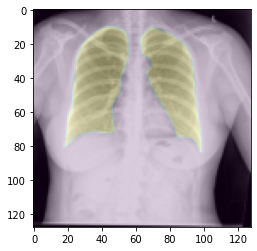

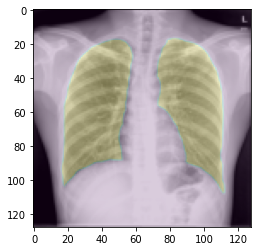

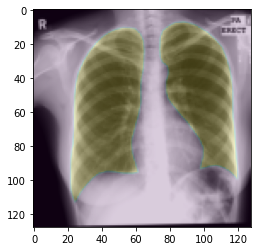

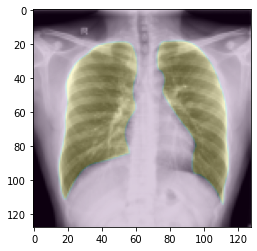

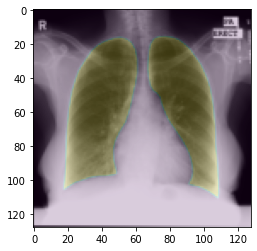

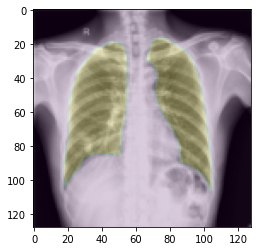

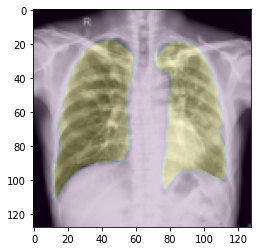

In [6]:
for i in range(dg_test.__len__()):
    X, Y = dg_test.__getitem__(index=i)
    plt.imshow(X[0,:,:,0], cmap = 'gray')
    plt.imshow(Y[0,:,:,0], alpha= 0.2)
    plt.show()

We wrote a data generator that should be called by another piece of code. Notebooks are very easy to be used but you can call a function defined in a ipynb.

So, we need to export the datagenerator in a .py file in order to call it from another notebook.